# Testowanie osiągów modelu na zbiorze testowym


In [1]:
%pip install torchvision
import torch
from model import CNN, load_model  # Twój model
from dataloader import load_data  # Ładowanie danych
from training import back_pass, test  # Funkcje treningu i testowania
from visualization import plot_mse, plot_classification_error, plot_all_weights  # Wizualizacje
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\kfedo\documents\studia\5 semestr\sieci_neuronowe2\venv\scripts\python.exe -m pip install --upgrade pip' command.


## Ładowanie modelu

In [2]:
# Wybór urządzenia (GPU lub CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Wczytanie modelu
model = CNN().to(device)
model = load_model(model, path="best_model.pth", device=device)
model.eval()


Using device: cpu
Model załadowano z best_model.pth


C:\Users\kfedo\Documents\studia\5 semestr\sieci_neuronowe2\model.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=dev

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=Tru

In [3]:
# Transformacja danych
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Zbiór testowy
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)


In [4]:
# Klasy CIFAR-10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Listy na poprawne i błędne klasyfikacje
correct_images = []
correct_labels = []
incorrect_images = []
incorrect_labels = []
incorrect_preds = []

# Przejście przez dane testowe
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    
    # Porównanie predykcji z rzeczywistą etykietą
    if predicted == labels:
        correct_images.append(images[0].cpu())
        correct_labels.append(labels[0].item())
    else:
        incorrect_images.append(images[0].cpu())
        incorrect_labels.append(labels[0].item())
        incorrect_preds.append(predicted[0].item())
    
   


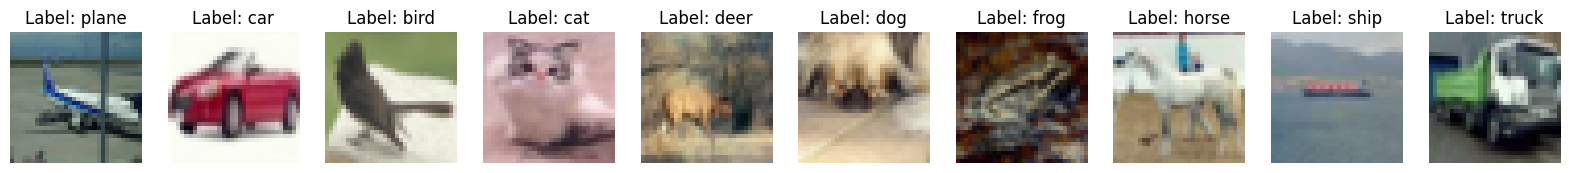

In [5]:
# Inicjalizacja tablic do przechowywania przykładów
correct_class_images = [None] * 10  # Jeden przykład na każdą z 10 klas
correct_class_labels = [None] * 10

# Iteracja przez poprawne obrazy
for img, label in zip(correct_images, correct_labels):
    if correct_class_images[label] is None:  # Jeśli jeszcze nie mamy przykładu dla tej klasy
        correct_class_images[label] = img
        correct_class_labels[label] = label
    
    if all(c is not None for c in correct_class_images):  # Jeśli mamy już po jednym przykładzie na każdą klasę
        break

# Wyświetlanie poprawnie przewidzianych obrazów (po jednym na klasę)
fig, axes = plt.subplots(1, 10, figsize=(20, 5))
for i, ax in enumerate(axes):
    if correct_class_images[i] is not None:
        image = correct_class_images[i].permute(1, 2, 0).numpy()  # Zmień kolejność wymiarów
        image = np.clip(image * 0.2470 + np.array([0.4914, 0.4822, 0.4465]), 0, 1)  # Denormalizacja
        ax.imshow(image)
        ax.set_title(f"Label: {classes[correct_class_labels[i]]}")
    ax.axis('off')
plt.show()


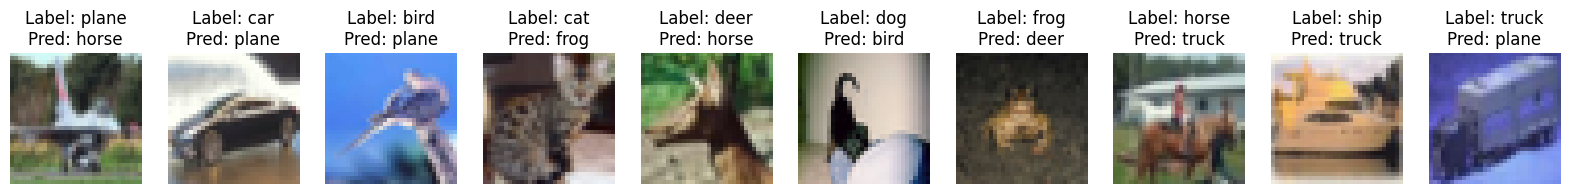

In [6]:
# Inicjalizacja tablic do przechowywania przykładów
incorrect_class_images = [None] * 10  # Jeden przykład na każdą z 10 klas
incorrect_class_labels = [None] * 10
incorrect_class_preds = [None] * 10

# Iteracja przez błędne obrazy
for img, label, pred in zip(incorrect_images, incorrect_labels, incorrect_preds):
    if incorrect_class_images[label] is None:  # Jeśli jeszcze nie mamy przykładu dla tej klasy
        incorrect_class_images[label] = img
        incorrect_class_labels[label] = label
        incorrect_class_preds[label] = pred
    
    if all(c is not None for c in incorrect_class_images):  # Jeśli mamy już po jednym przykładzie na każdą klasę
        break

# Wyświetlanie błędnie przewidzianych obrazów (po jednym na klasę)
fig, axes = plt.subplots(1, 10, figsize=(20, 5))
for i, ax in enumerate(axes):
    if incorrect_class_images[i] is not None:
        image = incorrect_class_images[i].permute(1, 2, 0).numpy()  # Zmień kolejność wymiarów
        image = np.clip(image * 0.2470 + np.array([0.4914, 0.4822, 0.4465]), 0, 1)  # Denormalizacja
        ax.imshow(image)
        ax.set_title(f"Label: {classes[incorrect_class_labels[i]]}\nPred: {classes[incorrect_class_preds[i]]}")
    ax.axis('off')
plt.show()


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt


In [8]:
y_true = []  # Lista rzeczywistych etykiet
y_pred = []  # Lista przewidywanych etykiet

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)  # Predykcja klasy
    
    y_true.append(labels.item())
    y_pred.append(predicted.item())

# Zamień listy na NumPy arrays (wymagane przez scikit-learn)
y_true = np.array(y_true)
y_pred = np.array(y_pred)


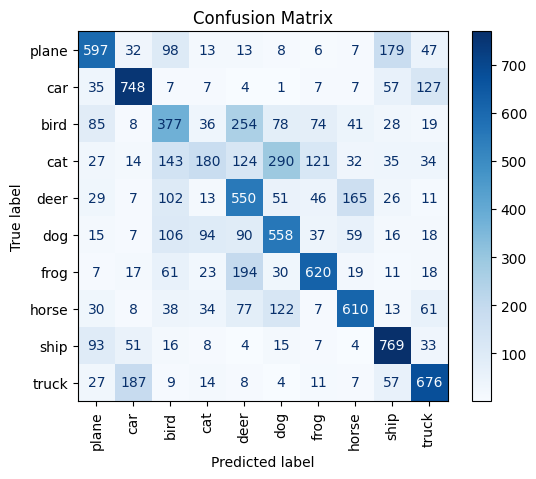

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obliczanie macierzy pomyłek
cm = confusion_matrix(y_true, y_pred)

# Klasy w zbiorze CIFAR-10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Wyświetlenie macierzy pomyłek
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()
